# 04. Building Makemore from scratch (Part3: Activations & Gradients + BatchNorm)

* Makemore makes more of the things you give it.
* makemore takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.
* it is basically a bigram character-level language model

**Resources:**

* makemore github repo: https://github.com/karpathy/makemore/tree/master

* tutorial lecture 4 (makemore part 3) code: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb

* MLP model based on 2003 paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

* makemore pre defined code: https://github.com/karpathy/makemore/blob/master/makemore.py

* link to youtube lecture 4: https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4

* whole lecture series code: https://github.com/karpathy/nn-zero-to-hero

## 0. Getting setup

* Before moving onto RNN and GRU and transformers we need to stick around to MLP for a while longer so that we can get a very intuitive understanding of the activations in a neural net during training, and especially the gradients that are flowing backwards and how they behave, and what they look like
  * this will be very important to understand the history of the development of these architectures because we'll see that although RNN's are very expressive in that they are a universal approximator and can in principal implement all the algorithms, we will see that they are not very easily optimizable with the first order gradient techniques we have available to us and we use all the time
  * the key to understanding why RNN's are not easily optimizable is to understand the activations and the gradients and how they behave during training
  * we'll see that a lot of the variants since RNN have tried to improve that situation



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://github.com/karpathy/makemore/raw/master/names.txt

--2024-08-24 15:16:27--  https://github.com/karpathy/makemore/raw/master/names.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karpathy/makemore/master/names.txt [following]
--2024-08-24 15:16:27--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.008s  

2024-08-24 15:16:27 (26.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


11897


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 27.8817
  10000/ 200000: 2.9415
  20000/ 200000: 2.5069
  30000/ 200000: 2.7998
  40000/ 200000: 2.0261
  50000/ 200000: 2.5863
  60000/ 200000: 2.3420
  70000/ 200000: 2.0952
  80000/ 200000: 2.3454
  90000/ 200000: 2.2365
 100000/ 200000: 2.1080
 110000/ 200000: 2.3831
 120000/ 200000: 1.9898
 130000/ 200000: 2.4591
 140000/ 200000: 2.1910
 150000/ 200000: 2.1606
 160000/ 200000: 2.1811
 170000/ 200000: 1.7997
 180000/ 200000: 2.0962
 190000/ 200000: 1.8052


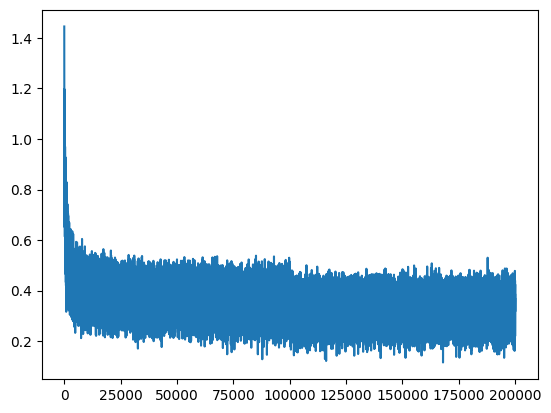

In [9]:
plt.plot(lossi)


* `@torch.no_grad()` tells PyTorch to not track gradients so quite more efficient as PyTorch does not need to keep track of a computational graph under the hood.
  * can also use a context manager with `@torch.no_grad()`

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.127678871154785
val 2.1750576496124268


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special `.` token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
nehayla.
remyra.
endrael.
adeer.
melin.
shy.
jen.
ede.
seananaraelyn.
malya.
cayshubergiaghan.
trickontelionnie.
cayus.
mace.
ryyah.
fael.
youe.


## 1. Fixing stuff

### 1.1 Fixing the initial loss

* the initial loss is almost 25 which is very bad
* often in building of neural nets it is common be able to predict your final loss after seeing the initial loss which just depends on the loss function and the problem setup
* at initialization what we would like is that there are 27 characters that can come up next for any one of the training examples, at initialization we have no reason to believe for any of the characters to be more likely than the others
  * we would expect that the probability distribution that comes out is a uniform one, assigning about equal probability for all the 27 characters
  * we would like that the probability for any character would be roughly 1/27 ~ 4% : that is the probability we should record, loss is the negative log of probability so we log(1/27)
  * what is currently happening is that the neural net is creating probability distributions that are all messed up, some characters are very confident, and some characters are very not confident -> the network is very confidently wrong and that's what makes it record very high loss
* the loss for a 4D example: 1.3863, once we manipulate the logits the loss changes as well. It could be that we lock out and by chance one of the logits could be a very high number like the 3rd one being `5` instead of all `0s` -> in that case the loss will be very low as we are assigning the correct probability by chance at initialization to the correct label
  * if the correct logit doesn't get the highest probability the loss will go up, e.g like `5` being assigned to the 2nd logit and the output shows very absurd probabilties and high loss
  * the more extreme the logits value from the correct one, the higher the loss
* we want the logits coming out of the neural net closer to 0
  * we are currently initializing `b2` with random values of the right size but now since we want roughly 0s we can't be adding random biases, so we multiply `b2` by 0 to keep `b2` as 0
  * since we want logits small, we'll be multiplying `W2` and making it small; we usually don't initialise `W2` to 0 but instead limit it to a small number, in our case over here it might work but things can go wrong easily
    * the loss isn't exactly 0 when `W2` is multiplied by 0.01 as it has got some entropy which is used for **symmetry breaking**
    * no hockey shaped loss plot graph because the optimization is just squashing down the logits and then it's rearranging them, so we just took the easy part of the loss function where just the weights were being shrunk down -> that is usually the case
    * loss is better because we're spending more cycles optimizing the neural net actually instead of just spending the first several 1000 iterations squashing down the weights as they are way too high at the beginning of the initialization

In [12]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [13]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [14]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [15]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


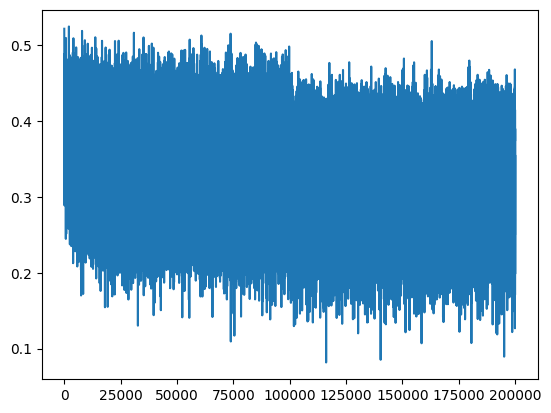

In [16]:
plt.plot(lossi);

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.1310746669769287


### 1.2 Fixing the saturated tanh

* although everything looks good in terms of loss, there is a much deeper problem inside the neural net and inside its initialization -> the values of `h` which are the activations of the hidden state
  * a lot of values for `h` are either 1 or -1
  * `tanh` is a squashing function: it takes arbitrary numbers and squashes them into a range of 1 to -1 and it does it smoothly so we look at the histogram of `h` to get a better idea of the distribution of the values inside this tensor
    * we can stretch it out by viewing it as **-1** to view it as one large vecotr and then use `tolist()` to convert this into one large python list of floats
    * we can also look at the pre-activations `hpreact` which come out to a very broad histogram that's why in `tanh` everything is being squashed and capped to be in the range of 1 to -1.
    * during backpropogation we're doing backward pass at the loss and then moving through the network backwards, in particular we're going to backpropogate through `tanh()` and that layer of activations is made up of 200 neurons for each one of these examples and it implements an element wise `tanh()`
      * (check micrograd code) what happens if the outputs of your `tanh()` are very close to 1 or -1, if you plug in t = 1 or t = -1 you basically kill the gradient and effectively stop the backpropogation through this unit:
      ```
      self.grad += (1 - t**2) * out.grad
      ```
      this makes sense because if `tanh` output is very close to 1, then we're in the tail of this `tanh` and so changing basically the input is not going to impact the output of the `tanh` too much because it's in the flat region of the `tanh`, therefore there is no impact on the loss, and indeed the weights and the biases along with this `tanh` neuron do not impact the loss because the output of this `tanh` unit is in the flat region of `tanh` and there's no influence, we can be changing however we want and loss is not impacted -> the gradient basically vanishes
      * the gradient flowing through `tanh` can only decrease and the amount it decreases is proportional to how far are you in that flat `tanh` -> the gradients flowing through this region will just get destroyed when t = 1 or -1
      * it can be redeemed:
        * first we check how often the activation `h` is in the flat layer -> white = true, black = false (it's boolean)
          * we would be in a lot of trouble if a whole column was white which would be called a **dead neuron** and this could be a `tanh` neuron where the initialization of the weights and the biases could be such that no such example ever activates this `tanh` in sort of the active part of the `tanh`. If all examples land in the tail, the nuron will never learn and hence will be a dead neuron -> not in our case so the neuron does have some examples which activates it in the active part of the `tanh` so some gradients will flow through and the neuron will learn and change
          * this is the case with many other activation functions as well as they are either squashing functions or a flat region -> when in an activation function a neuron never activates or starts learning the **gradient becomes 0**. This can not only happen in backpropogation but in optimization as well in ReLU where the learning rate is too high that some of the neurons get too much of a gradient and they get knocked out of the data manifold and what happens is that no example ever activates this neuron and it remains that way forever
        * `hpreact` needs to be closer than 0 so:
          * turning `b1` to multiply by 0.01 to cause them to have some kind of entropy, this causes there to be a little bit of variation and diversity in the original initialisation of these `tanh` neurons and it can help optimization a little bit
      * `hpreact` going into `tanh` is too extreme, it's too large, it's creating a distribution that's too saturated which is what we don't want because it means there is less training for these neurons because they update less frequently
    * by fixing `tanh` our initialization is better and we're spending more time being productive training since we have to learn very simple things like the overconfidence of `softmax` in the beginning and we're spending cycles squashing down the matrix
* we're working with a very small model with only one layer in MLP, so becuase the network is so shallow the optimization problem is quite easy and very forgiving so although the initialization is terrible, the network still learned eventually, it just got a bit worse result -> not the case in general. Once we actually start working with deeper networks, things get can get much more complicated and these problems can stack up, which can lead you to have a network that isn't learning at all. The deeper your network is and the more complex it is, the less forgiving it is on these errors.


In [18]:
h, h.shape

(tensor([[ 0.7100, -0.7879, -0.7424,  ..., -1.0000,  1.0000,  1.0000],
         [-0.5614, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9210],
         [-1.0000,  0.9940, -1.0000,  ...,  0.3851, -0.9303,  0.3262],
         ...,
         [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
         [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
         [-1.0000, -0.9995, -1.0000,  ..., -0.6407, -0.8208,  0.5100]],
        grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

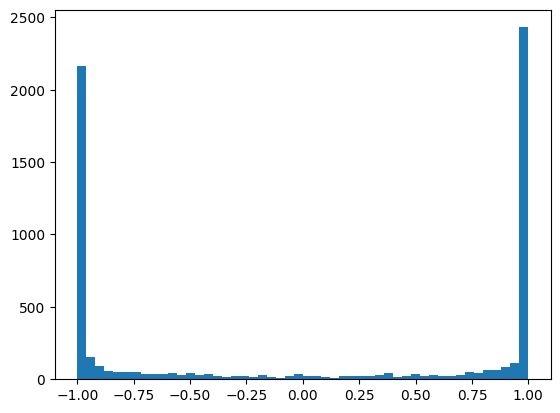

In [19]:
# before fixing `tanh`
plt.hist(h.view(-1).tolist(), 50);

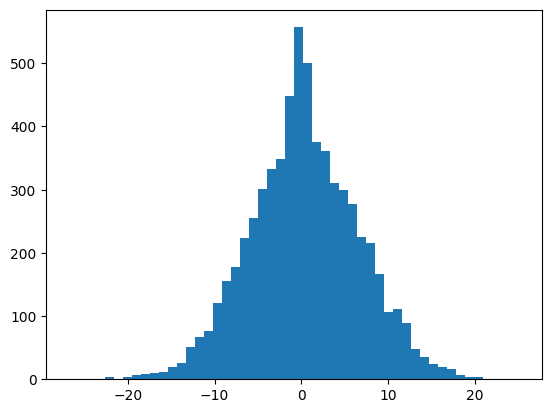

In [20]:
# before fixing `tanh`
plt.hist(hpreact.view(-1).tolist(), 50);

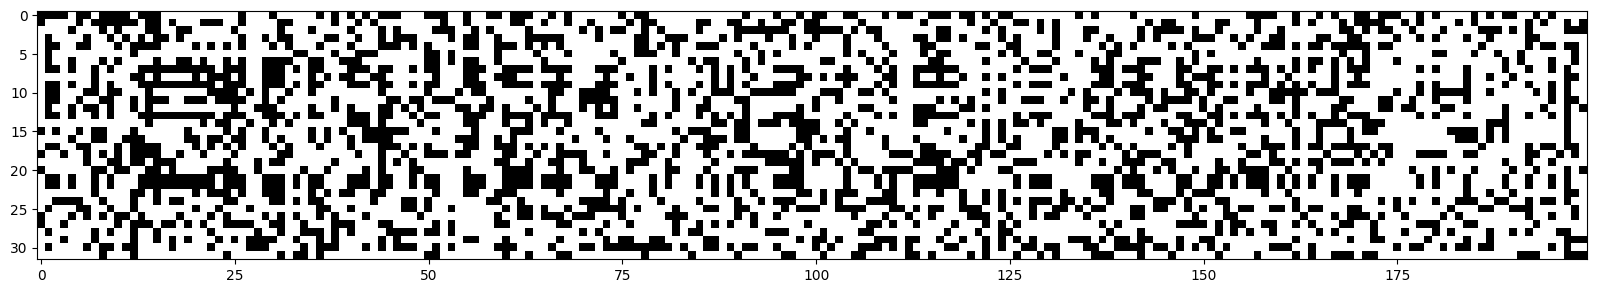

In [21]:
# checking how many time `h` is in flat layer of `tanh`: before fixing `tanh`
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest');

In [22]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


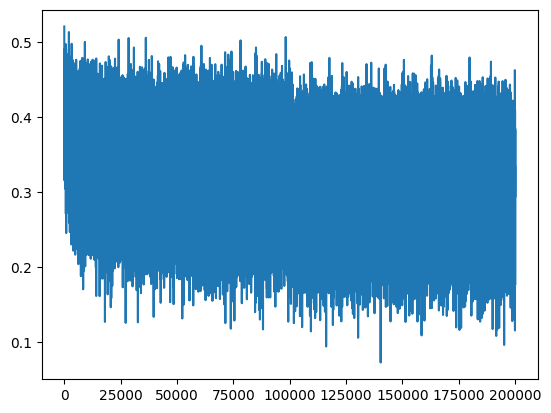

In [24]:
plt.plot(lossi);

In [25]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


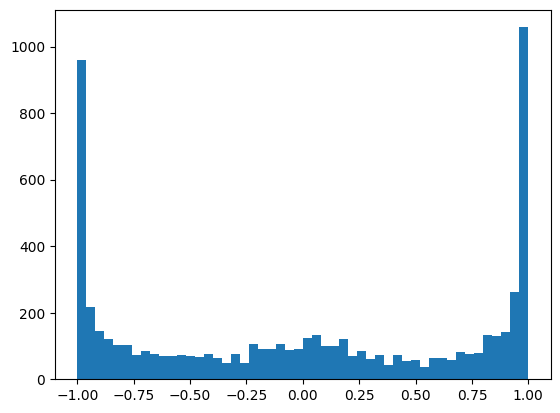

In [26]:
# after fixing `tanh`
plt.hist(h.view(-1).tolist(), 50);

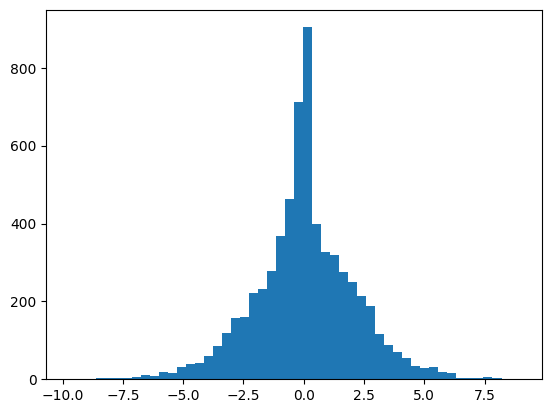

In [27]:
# after fixing `tanh`
plt.hist(hpreact.view(-1).tolist(), 50);

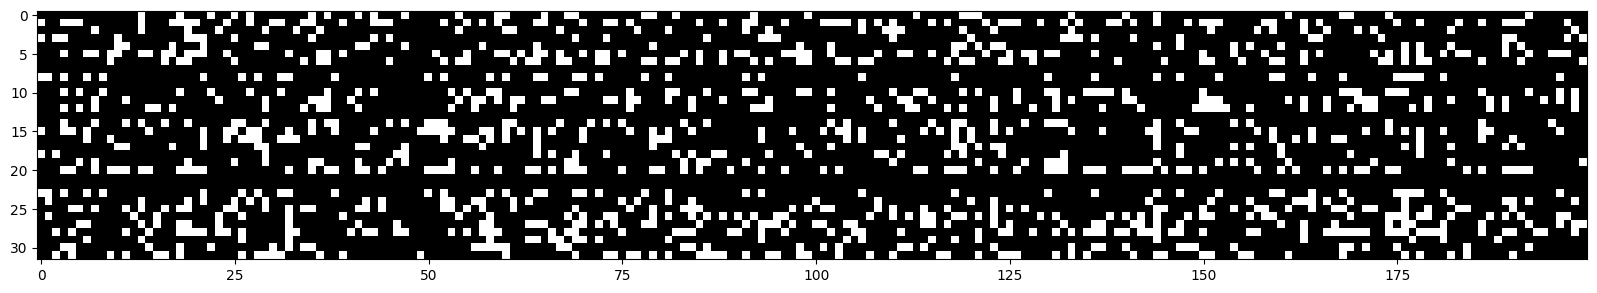

In [28]:
# checking how many time `h` is in flat layer of `tanh`: after fixing `tanh`
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest');

#### current loss log

* original:
train 2.1245384216308594 val 2.168196439743042

* fix softmax confidently wrong:
train 2.07 val 2.13

* fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744


### 1.3 Calculating the init scale: "Kaiming init"

* how am i supposed to set the changes to the weights and biases when i have a much deeper network with lots of layers
* we are expanding the gaussian from the input and we don't want that, we want most of the neural nets to have relatively similar activations so unit gaussian throughout the neural net
* how do we scale these weights to preserve this distribution to remain a gaussian?
  * when you multiply the weight by a large number, the gaussian grows and grows into a large std, so the numbers in `y` take on more extreme values
  * if we scale it down, conversely the gaussian gets smaller and smaller, it shrinks.
  * working out the variance by dividing the weights by (square root of `number of elements`)
* in MLP, we can have fairly deep networks that have these non-linearities in between, and we want to make sure the activations are well behaved and they don't expand to `inf` or shrink to 0 so the question is how do we initialise the weights so that these activations take on reasonable values throughout the network
  * mentioned in **"Delving deep into Rectifiers: surpassing human-level performance on ImageNet Classification" by Kaiming He**: they studied CNN and the ReLU and Non-ReLU non-linearity but the analysis is pretty similar:
    * ReLU is a squashing function where all the negative numbers are simply clamped to 0, so the positive numbers are passed through but every thing negative is just set to 0 and because we're throwing away half of the distribution they find in their analysis of the forward activations of the neural net that you have to compensate for that with a gain:
      * have to initialise weights with a zero mean gaussian distributin and std of sqrt(2/number of elements or fan(n)) -> they have to add 2 to remove half of the distribution in ReLU and clamps it at 0
      * the paper not only studies the behaviour of the activation and forward pass of the neural net but it also studies the backpropogation, so we have to make sure the gradients are also well behaved as they end up eventually updating our parameters -> if you properly initialise the forward pass, the backward passes also approximately initialises
      * this kind of initialization for neural networks is implemented in PyTorch through `torch.nn.init.kaiming_normal_` where it asks:
        * would you like to normalise the activation or the gradients to be always gaussian with zero mean and unit std -> since it doesn't matter too much according to the paper it is left as `fan_in` (default)
        * non-linearity to calculate the slightly diffrent gain, if there is no non-linearity (data is linear) gain will be entered as 1. Intuitively, we need gain on top of the initialization because `tanh` just like `ReLU` is a contractive transformation - so that means you're taking output distribution from the matrix multiplication and then you're squashing it in someway. `ReLU` squashes everything below 0 to 0, `tanh` also squashes it because it is a contractive operation; in order to fight the squeezing in we need to boost the weights a little bit so that we re-normalize everything back to unit std.
      * back when the paper was realized, everything was very unstable so had to be. initialized very carefully but modern upgrades like residual connections, the use of a number of normalization layers like BatchNorm LayerNorm, complex optimizers like Adam. In practice, while initializing these neural nets, just normalize them by `sqrt(fan_in)`:
        * std = gain/sqrt(fan_in)
        * whatever number you multiply with becomes your std of the gaussian
        * gain for `tanh` = (5/3) / sqrt (fan_in) -> for W1 it is 30 because `n_embd * block_size`
    * loss doesn't change by much by using `kaiming init` but we are not randomly guessing which value to multiply our weights with to normalize them, instead they are stable

In [29]:
torch.randn(10000).std() # spread of gaussian of zero mean and unit std

tensor(1.0140)

In [30]:
(torch.randn(10000) * 0.2).std() # scaled down the gaussian

tensor(0.2013)

In [31]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


tensor(0.0039) tensor(0.9951)
tensor(-0.0021) tensor(1.0045)


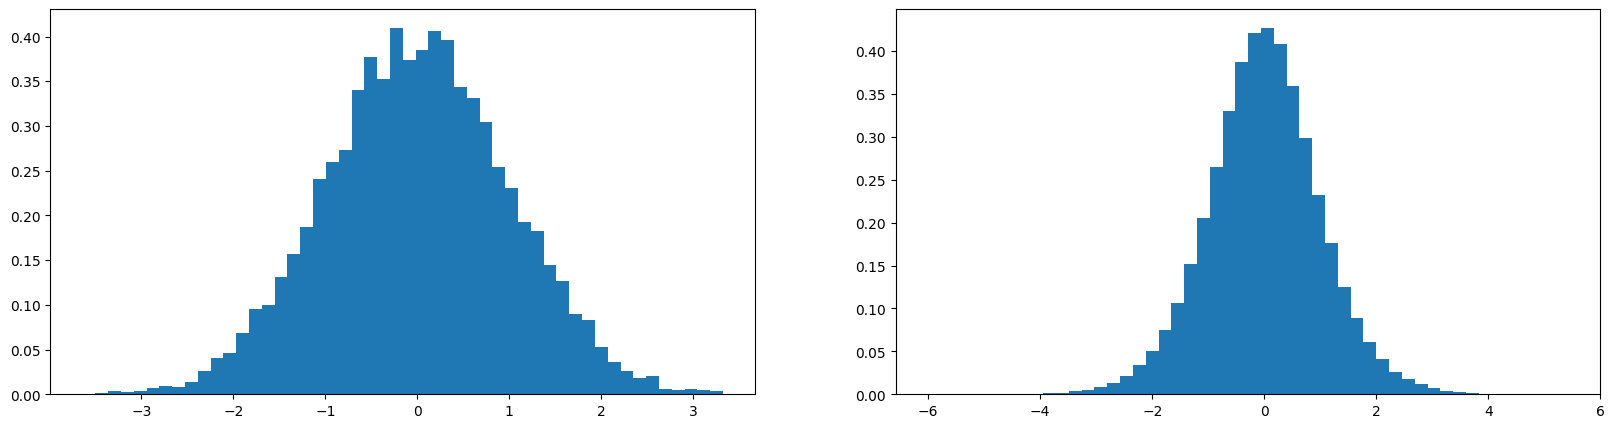

In [32]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [33]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [34]:
# after "kaiming init"
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


#### current loss log

* original:
train 2.1245384216308594 val 2.168196439743042

* fix softmax confidently wrong:
train 2.07 val 2.13

* fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

* use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

## 2. Batch Normalization



* it made it possible to train very deep neural nets quite reliably
* basically we have the hidden layer `hpreact`, and we discussed how we don't want the pre-activation layers to be too small because then the `tanh` is not doing anything because we don't want them to be too large because then the `tanh` is saturated,we want them to be roughly gaussian (atleast at initialization) -> so that's exactly what BatchNorm does: normalizes the hidden layers to unit Gaussian
  * `hpreact` or pre-activation layers to be roughly Gaussian because if these are way too small numbers then `tanh` is kinda inactive, but if the numbers are way too large then the `tanh` will saturate and the gradient will not flow
  * we will standardise or normalize these `x's` (given in the batchNorm paper) by subtracting the mean and dividing by std
  * every neuron now in its firing rate will be exactly unit gaussian on these 32 examples of the specific batch
  * this will not work well because we want them to be unit gaussian only at initialization and we don't want them to be forced gaussian always. We would actually like to allow the neural net to move this around to potentially to make it more diffuse, to make it more sharp, to make some 10 neurons more trigger happy or less trigger happy so we'd like this distribution to move around and we'd like the back propogation to tell us how that distribution should move around
  * in additoon to the idea of standardizing the activations at any point in the network, we have to also introduce this additional component as described in the paper for scale and shift. So basically what we're doing is that we're taking these normalized inputs and we're additionally scaling them by some gain and offsetting them by some bias to get our final output from this layer
    * we are going to allow a batch normalization gain `bngain` to be initialized at just ones, and the ones will be in the shape of 1 by n hidden
    * we will also have a `bnbias` that will be inititalized at zeros and will have the same shape as `bngain`
    * `bngain` will mutliply `hpreact` and `bnbias` will then offset it -> this will make it unit gaussian at initialization just like we want
    * during optimization we will be able to backpropogate to `bngain` and `bnbias` and change them so the network is getting the full ability to do with this whatever it wants internally. We include `bngain` and `bnbias` in the parameters of the neural net as they will be trained in backpropogation
    * we didn't expect a lot of improvement here because we are dealing with a very simple neural net which just has a one hidden layer
      * in fact in this simple case of one hidden layer we were able to calculate what the scale of W should be for these preactivations to have a rough a gaussian shape so BatchNorm is not doing much here. Once we have a deeper neural net with Residual connections, it will become basically very difficult to tune the scales of the weight matrices, such that all the activations throughout the neural net are roughly gaussian. Compared to that, it will be much much easier to sprinkle batch normalization layers throughout the neural net
      * so in particular its common to look at every single linear layer like `hpreact = embcat @ W1 + b1` or convolutional layer  and append a batch normalization layer after it control the scale of activations at every point of the neural net. Significantly stablizes the training.
        * the stability provided by BatchNorm comes at a terrible cost and that cost is that if you think about what's happening in `hpreact mean and std layer`, something very unnatural is happening: it used to be that we have a simple example feeding into the neural net and then we calculate its activations and its logits and this is a deterministic process so we arrive at some logits, and because of effciency of training we start using batches of examples but those batches of examples were processed independently and it was just an efficiency thing. But now because of the normalization through the batch we are coupling these examples mathematically and in the forward and backward pass of the neural net. So now the hidden state activations `hpreact` and your logits for any one input example are not just a function of that example and its input, but they're also a function of all the other examples that happen to come for a ride in that batch and these examples are sampled randomly.
        * what's happening is for example when you look at `hpreact` which is going to feed into `h`, the hidden state activations for one of these input examples is going to actually change slightly depending on what other examples are there in the batch, and depending on what other examples happen to come for a ride, `h` is going to change subtly and it's going to like jitter if you imagine sampling different examples because the8 statistics of the mean and std are going to be impacted -> so you'll get a jitter for `h` and you'll get a jitter for `logits`, and you think this would be a bug but in a very strange way this turns out to be good in neural network training and as a side effect and the reason for that is that you can think of this as a kind of like a regularizer because of what's happening is that you have your input and you get your `h` and then depending on the other examples this is jearing a bit, so what that does this is that is effectively padding out any one of these input examples and it's introducing a little bit of entropy and because of the padding out it's like a form of data augmentation for the input, and that makes it harder for the neural net to overfit to these concrete specific examples so by introducing all this noise, it actually pads out the examples and it regularizes the neural net
        * that's one of the reasons why deceivingly as a second order effect this is actually a regularizer and that has made it harder for us to remove the use of batch normalization because basically no one likes this property that the examples in the batch are coupled mathematically, and in the forward pass it leads to  all kinds of strange results and bugs. People have thus tried to deprecate the use of batch normalization and move to other normalization techniques that do not couple the examples in a batch e.g layer normalization, instance normalization, group normalization etc.
  * in short, BatchNorm was the first kind of normalization to be introduced, it worked extremely well and happens to have this regularizing effect. It stablized training and people have been trying to remove it and move to some kind of other normalization techniques but it's been hard because it just works quite well, again because of this regularizing effect and because of it is quite effective at controlling the activations and their distributions
* another weird thing about BatchNorm can be noticed when evaluating the loss on the validation set, basically once we've trained a neural net we would like to deploy it in some kind of a setting and we'd like to be able to feed in a single individual example and get a prediction out from our neural net, but how do we do that when our neural net expects batches as an input instead of an individual example. The proposal in the batch normalization paper is the following:
  * we would like to have a step after training that calculates and sets the BatchNorm mean and std a single time over the training set: `see calibrating batch norm code`: we will one time estimate the mean and std for the entire training set, and then we'll get `bnmean` and `bnstd` which are fixed numbers estimated with the entire training set
  * we get identical result but the benefit we've gained is that now we can also forward a single example because the mean and std are fixed tensors
  * we can estimate `bnmean` and `bnstd` in a running manner during training of the neural net and then we can simply just have a single stage of training and on the side of that training we are estimating the running mean and std; however, `bnmean_rnning` and `bnstd_running` are not part of the gradient based optimization, we're never going to derive gradients w.r.t them (they are updated outside and on the side of training) -> **not updated using gradient descent**
    * we hope that `bnmean_running` and `bnstd_running` are similar to `bnmean` and `bnstd` because that way we don't need a second stage because we've sort of combined the 2 stages and we've put them on the side of each other. This is how it's also implemented in BatchNorm layer in PyTorch -> during training the exact same thing will happen, and later when you're using inference it will use the estimated running mean of both the mean and std of those hidden states
    * we have eliminated the need for a seperate mean and std update, or explicit stage of calibration, as we are updated `bnmean_running` and `bnstd_running` in the optimization loop itself
  * the epsilon usually like some small fixed number (default 1e-5), it is basically preventing a division by zero in the case that the variance over your batch is exactly 0 (skipping in our case since rare to happen in our simple model)
  * we're being wasteful when we're adding `b1` in `hpreact = embcat @ W1 + b1` in the optimization loop, we are calculating the mean for every one of these neurons and subtracting it so whatever bias you add here is going to get subtracted in the next `hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias` statement -> hence, these biases are not doing anything, in fact they're being subtracted out and they don't impact the rest of the calculation, so if we look at `b1.grad` it's actually going to be 0 because it's being subtracted out and doesn't have any effect
  * so whenever you're using batch norm layers and you have any weight layers before like linear or conv, you're better off not using bias -> `bnbias` is now in charge of the bias in BatchNorm instead of `b1` originally.
  * in conclusion, BatchNorm has its own bias so we don't a bias in the layer before it as it'll be subtracted anyways

In [52]:
hpreact.shape

torch.Size([182625, 200])

In [53]:
hpreact.mean(0, keepdim = True).shape # we are doing the mean over all the elements in the batch

torch.Size([1, 200])

In [54]:
# calculating std of these activations
hpreact.std(0, keepdim = True).shape

torch.Size([1, 200])

In [55]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [49]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @  W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # ------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch norm
  with torch.no_grad(): # no backward()
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # batch norm
  # -------------------------------
  # non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3218
  10000/ 200000: 2.0864
  20000/ 200000: 2.5199
  30000/ 200000: 2.0145
  40000/ 200000: 2.2294
  50000/ 200000: 1.9475
  60000/ 200000: 2.1230
  70000/ 200000: 2.2506
  80000/ 200000: 2.2882
  90000/ 200000: 2.0588
 100000/ 200000: 2.2716
 110000/ 200000: 2.3241
 120000/ 200000: 1.6816
 130000/ 200000: 1.9691
 140000/ 200000: 2.2135
 150000/ 200000: 1.9717
 160000/ 200000: 2.0459
 170000/ 200000: 2.4531
 180000/ 200000: 2.0450
 190000/ 200000: 2.1171


In [50]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True) # fixed numbers
  bnstd = hpreact.std(0, keepdim=True)

In [51]:
# after BatchNorm
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068894624710083
val 2.1077334880828857


#### current loss log

* original:
train 2.1245384216308594 val 2.168196439743042

* fix softmax confidently wrong:
train 2.07 val 2.13

* fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

* use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

* add batch norm layer
train 2.070009469985962 val 2.1077067852020264

### 2.1 Summary

* There is a batch normalization layer to control these statistics without activations in your monitor. It is common to spread the batch normalization layer across the neural network, and usually we will place it after layers that have multiplications, like, for example, a linear layer or a convolution layer, which we may cover in the future.

* Now, the batch normalization internally has parameters for the gain and the bias, and these are trained using back propagation. It also has two buffers. The buffers are the mean and the standard deviation.

* The running mean and the running mean of the standard deviation. And these are not trained using back propagation. These are trained using this janky update, kind of like a running mean update. So these are sort of the parameters and the buffers of batch normalization.

* And then really what it's doing is it's calculating the mean and the standard deviation of the activations that are feeding into the batch normalization layer over that batch. Then it's centering that batch to be unit Gaussian, and then it's offsetting and scaling it by the learned bias and gain.

* And then on top of that, it's keeping track of the mean and standard deviation of the inputs, and it's maintaining this running mean and standard deviation. And this will later be used at inference, so that we don't have to re -estimate the mean and standard deviation all the time.

* And in addition, that allows us to basically forward individual examples at this time. So that's the batch normalization layer. It's a fairly complicated layer, but this is what it's doing in turn.

## 3. Example 1: resnet50 walkthrough



* check the code here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

* convolutional layers are linear layers except on patches
* resnet: residual neural network, these are contact of neural network used for image classification
  * image feeds onto the resnet from the top and there's many many layers with repeating structure all the way to predictions of what's inside that image.
  * this repeating structure is made up of these blocks and these blocks that are sequentially stacked up in this deep neural network are called **bottleneck blocks**
  * `def __init__` is where you initialize the neural network with its weights and biases and in the `forward` pass we are specifying how the neural network acts once you actually have the input, similar to the optimization loop above. These blocks now being stacke dup sequentially are known as a residual network
  * these are convulotional layers existing in the blocks, which are the same thing as a linear layer except convolutional layers apply for images so they have spatial structure and basically the linear mutiplication and bias offset are done on patches instead of the full input. Since these images have spatial structure, convolutions just do `Wx + b` but they do it on overlapping patches of the input but otherwise it's `Wx + b`
  * then we have the norm layer which by default is initialised here to be a batchNorm in 2D, and then we have a non-linearity like ReLU (works better for deeper neural networks), so instead of using ReLU we are using `tanh()` above:
  ```
  conv layer (linear/weight layer) -> BatchNorm -> ReLU or tanh (non-linearity layer)
  ```
  -> then a residual connection follows (not covered yet)
  * when it initialises a Conv2d layer it keeps `bias` as false just like us because the use of bias is spurious because after this weight layer there's a batch normalization and the batch normalization subtracts that bias and then has its own bias so there's no need to introduce these spurious paramters, it won't hurt performance but it's useless

* instead of a conv layer we're going to look at a linear layer because that's what we're going to be using moving forward as well:
  * linear layer perfroms `Wx + b`
  * to initalise this layer you need to know `fan_in` and `fan_out` so that they know how big the weight matrix should be
  * you also need to pass in whether or not you need a bias
    * particularly do this if you have got a normalization layer like BatchNorm after your linear layer like we did above
  * by default, PyTorch will initialize your weight by taking the `fan_in` and then doing `sqrt(1/fan_in)` -> instead of a normal (gaussian) distribution, they're using a uniform distribution (from sqrt(k) to sqrt(-k))
    * the reason PyTorch does this is because if you have a roughly gaussian input, this will ensure that out of this layer, you will have a roughly gaussian output and you basically achieve that by scaling the weights by `sqrt(1/fan_in)`
    * the batch normalization layer in pytorch is 1D
      * we need to know the number of features and for us that's 200 and that is needed so we can initialise the BatchNorm parameters particularly `bngain` `bnbias` and the batchnorm buffers `bnmean_running` and `bnstd_running`, then we need to know the value of epsilon (default 1e-5), then we need to know the momentum which is used for the running mean and running std (default = 0.1 but we used 0.001)
        * if you have a very large batch size, when you estimate the mean and std for every single batch size, if it's large enough, you're going to get roughly the same result and so therefore you can use slightly higher momentum like 0.1. Howeever, for a batch size small like 32 like ours, the mean and std might take on slightly different numbers because there's only 32 examples we are using to estimate the mean and std so the value is changing around a lot, and if your momentum is 0.1 that might not be good enough for this value to settle and converge to the actual mean and std over the entire training set.
      * `affine = True` determines whether the batchNorm layer has learnable affine parameters, the gain and the bias and this is almost always kept to True
      * `track running stats` is determining whether or not batch normalization layer of pytorch will be running this:
      ```
      with torch.no_grad(): # no backward()
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    ```
      * one reason you might wanna skip the running stats is because you might want to estimate them at the end as a stage 2, and in that case you don't want batch normalization to be doing all this extra compute that you're not going to use.
    * Finally we need to know which device we're going to run this batch normalization layer on, a CPU or GPU, and what the datatype should be: half precision, single precision, double precision



## Summary (uptil now)



* The importance of understanding the activations and gradients and their statistics in your networks becomes increasingly important, especially as you make your networks bigger and larger and bigger.

* We looked at the distributions basically at the output layer, and we saw that if you have too confident in these predictions, because the activations are too messed up at the last layer, you can end up with these optimistic losses.
And if you fix this, you get a better loss at the end of training, because your training is not doing wastefully well. Then we also saw that we need to control the activations. We don't want them to squash to zero or explode to infinity, and because of that, you can run into a lot of trouble with all of these nonlinearities in these layers. And basically, you want everything to be fairly homogeneous throughout the board. You want roughly Gaussian activation throughout the neural network.

* If we want roughly Gaussian activations, how do we scale these weight matrices and biases during initialization of the neural network so that everything is as controlled as possible? So that gave us a lot of boost in the learning. And then we saw how that strategy is not actually possible for much, much deeper neural nets. Because when you have much deeper neural nets with lots of different types of layers, it becomes really, really hard to precisely set the links and the biases in such a way that the activations are roughly uniform throughout the network. So then we introduced the notion of normalization.

* Now, there are many normalization layers that people use in practice. Batch normalization, layer normalization, distal normalization, group normalization. We haven't covered most of them, but I've introduced the first one. And also, the one that I believe came out first, and that's called batch normalization. And we saw how batch normalization works. This is a layer that you can sprinkle throughout your deep neural net. And the basic idea is if you want one-field Gaussian activations, well then take your activations and take the mean and standard deviation and center your data and you can do that because the centering operation is differential. But on top of that we actually have to add a lot of buzz and that's giving you a sense of the complexities of the rationalization because now we're centering the data, that's great, but suddenly we need the gain and the bias.

* Now there's our training. And then because we are coupling all the training examples, now uddenly the question is how do you do the inference? To do the inference, we need to now estimate these mean and standard deviation once for the entire training set, and then use those as inference. But then no one likes to use stage 2, so instead we fold everything into the batcharalization and training, and try to estimate these in the running manner, so that everything is fixed. And that gives us the rationalization layer. And as I mentioned earlier in the code, no one likes this layer. It causes a huge amount of bugs, and intuitively it's because it is coupling examples in the forecast of the neural network. So basically try to avoid it as much as possible. Some of the other alternatives to these layers are, for example, group normalization or layer normalization.And those have become more common in more recent deep learning. But we haven't covered those yet. But definitely batch normalization was very influential at the time when it came out in roughly 2015, because it was kind of the first time that we could train reliably much deeper neural nets. And fundamentally the reason for that is because this layer was very effective at controlling the statistics of the activations in your neural network.

* So that's the story so far. In future lectures, hopefully we can start going into recurrent neural nets, as we'll see, are just very, very deep networks, because you unroll the loop when you actually optimize these neural nets. And that's where a lot of this analysis around the activation statistics and all these normalization layers will become very, very important for good performance.

 ### **SIKE!**

## 4. Pytorchifying code



* we skip `device` and `datatype` as the parameters of `torch.nn`.
* Parameters:
  * `fan_in` = number of inputs
  * `fan_out` = number of outputs
  * we internally have a `weight` and a `bias` -> typical to initalize `weight` with random number from the gaussian and the `bias` to 0  
  * we'll be using `affine` as true that means we'll be using both a gamma and a beta after normalization, the track running stats will be true so we'll be keeping track of running mean `xmean` and running var `xvar` in the batchNorm
  * our device by default is CPU and the datatype by default is float32
* first we just save the parameters
  * `self.training` is set to true and pytorch nn modules also have this attribute .training. This is because many modules and BatchNorm is included in that have a different behaviour of whether you are training your neural net or whether you are running it in an evaluation mode and calculating your evaluation loss or using it for inference on a few test examples. BatchNorm is an example of this since when we are training, when we'll be using mean and variance estimated from the current batch but during inference we are using the running mean and running variance and so also if we are training we are also updating the mean and variance, but if we are testing they don't update rather remain fixed -> hence, this flaf is unnecessary and is true by default
  * the buffers `running_mean` and `running_variance` are trained using exponential moving average, and are not part of the backpropogation and the stochastic gradient descent so they are not sort of like paramters of this layer, and that's when we train we only return gamma and beta, we don't return the mean and the variance as they are trained sort of internally her every forward pass using exponential moving average
  * now in the forward pass if we are training, we use the mean and the variance estimated by the batch, otherwise we if are not training then we use the `running_mean` and `running_var`, we normalize
  * we maintain the output in `self.out` which is helpful for plotting statistics (not seen in usual PyTorch)
  * we use the `torch.no_grad()` context manager when updating the buffers using exponential moving average given the provided momentum because pytorch will start building out entire computational graph out of these tensors because it is expecting that we will eventually call `.backward()` but we will never do that actually on something that includes running mean and running variance -> we don't need to maintain them using additonal memory
  * since these are all layers it becomes very easy to just stack them as a list and we can do all the inititalization that we're used to so we have the initial embedding matrix, we have our layers and we call them sequentially and then with the `torch.no_grad()` we have some initializations:
    * we want to make the output `softmax` a bit less confident and in addition to that since we're using a 6 layer MLP we'll be using gain as well
  * the parameters are the embedding matrix and all the parameters in all the layers. We use a double list comprehension but for every layer in layers and for each parameter in each of those layers we are just stacking up all those parameters
  * in total we have 46k parameters and all of them require gradient
  * in the optimization loop we have the things we're used to
    * we are sampling batch
    * we have the forward pass (linear applicaiton of all the layers in order)
    * we call `cross_entropy`
    * in the `backward` pass for every single layer we know iterate over all the outputs and pytorch has to return the gradient of them
    * do the update of gradient using schocastic gradient descent and then track some statistics


In [109]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [110]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.2988


#### results for above optimization loop

```
     0/ 200000: 2.6092
  10000/ 200000: 2.4249
  20000/ 200000: 2.0732
  30000/ 200000: 2.3529
  40000/ 200000: 2.1160
  50000/ 200000: 2.0177
  60000/ 200000: 2.0626
  70000/ 200000: 1.9917
  80000/ 200000: 2.0937
  90000/ 200000: 2.1961
 100000/ 200000: 2.2995
 110000/ 200000: 2.3715
 120000/ 200000: 1.8299
 130000/ 200000: 1.9228
 140000/ 200000: 2.1635
 150000/ 200000: 2.2194
 160000/ 200000: 1.9798
 170000/ 200000: 2.0652
 180000/ 200000: 1.8019
 190000/ 200000: 2.1666
```

## 5. Visualizing stuff

### 5.1 Viz # 1: forward pass activations

* using `tanh` as they give an output between 1 and -1 so it's very easy to visualize
* saturation is defined as the value of absolute `tanh` being greater than 0.97 which means we are at its tail that will stop the gradients, we don't want this to be too high
* we are looking at different layers, and how many values in these tensors take on any of the values below on this axis
* the reason it stablizes and gives us a nice distribution is because gain is set to 5/3 which keeps the std at 1
* by default we initialize the gain as `sqrt(1/fan_in)` but then in initialization we iterate over all the layers, and if it is a linear layer we boost that by the gain (if we don't use a gain the std shrinks and the saturation leads to 0) -> this is because when you have a sandwich of linear layers flowing, the `tanh` being a squashing function, and they take the distribution slightly and they squash it and so some gain is necessary to keep expanding it and stop the squashing

layer 1 (      Tanh): mean -0.04, std 0.64, saturated: 5.19%
layer 3 (      Tanh): mean -0.01, std 0.54, saturated: 0.41%
layer 5 (      Tanh): mean +0.01, std 0.53, saturated: 0.47%
layer 7 (      Tanh): mean -0.02, std 0.53, saturated: 0.28%
layer 9 (      Tanh): mean +0.01, std 0.54, saturated: 0.25%


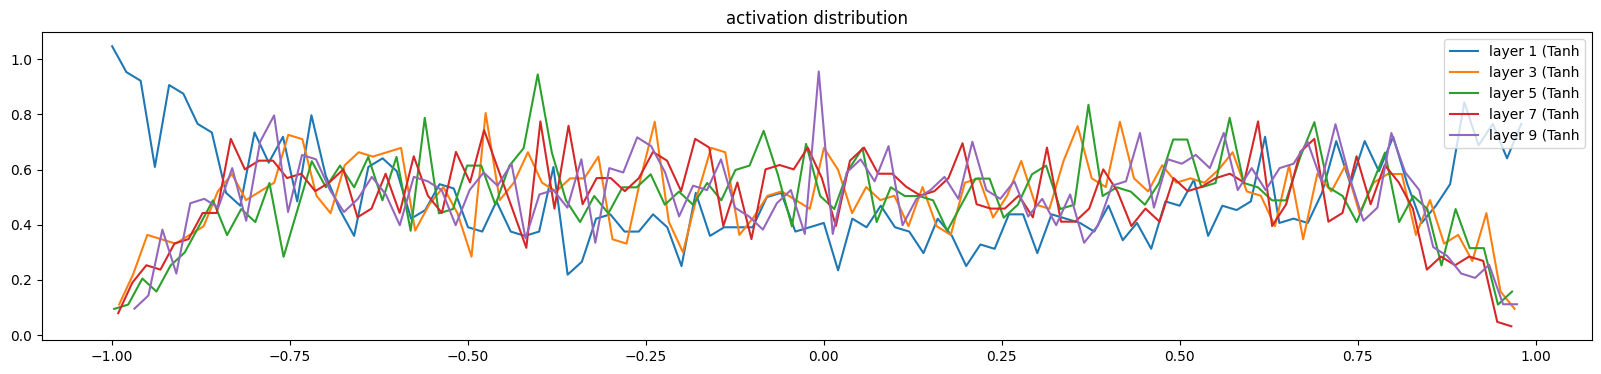

In [111]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

### 5.2 Viz #2: backward pass gradient

* instead of taking the `layer.out`, we take its `grad` and then we also show the mean and std
* what we are looking for is that all these different layers in the sandwich has roughly the same gradient, things are not shrinking or exploding
* if the `gain` is too small like 0.5, the activations shrink to 0 but also the gradients are doing something weird expanding out
* if the `gain` is too high like 3, there's some asymmetry going on as we go into deeper and deeper layers with the activations also changing
* without the use of BatchNorm like right now, we have to very carefully set those gains to get nice activaittions in both the forward and backward pass


layer 1 (      Tanh): mean +0.000033, std 2.641852e-03
layer 3 (      Tanh): mean +0.000043, std 2.440831e-03
layer 5 (      Tanh): mean -0.000004, std 2.338152e-03
layer 7 (      Tanh): mean +0.000006, std 2.283551e-03
layer 9 (      Tanh): mean +0.000040, std 2.059027e-03


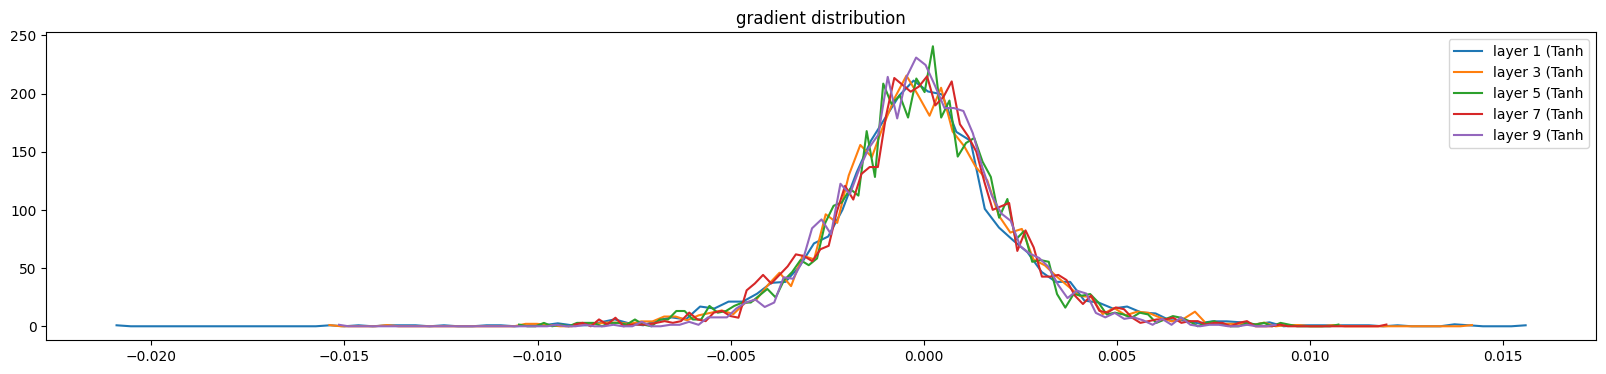

In [112]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

### 5.3 Removing non-linearities

(for some reason graphs don't load)

* we erase all the `tanh()` non-linearities but keep the `gain` at 5/3 we just now have a giant linear sandwich
* the correct gain is 1 which preserves the std so 5/3 is too high
* when gains are high, what will happen now to the activations is that they spread out laying out from its edges, and its gradients diminish as well as you go down deeper in the layers and so basically you have an aysmmetery and if you have very deep neural networks like 50 layers, it's not a great place to be
* before batch normalization it was pretty tricky to set, almost impossible
* when gains are little, the opposite happens. We have a shrinking and diffusion
* in this case the correct setting of gain is 1 like at initilization
* why do we need these `tanh` layers at all and then have to worry about the gain?
  * if we just have a stack of linear layers, with the nice gain of 1 we do get nice activations but it turns out these linear layers collapse into a single linear layer in terms of its representation power. If we were to plot the output in reference to an input, we're just getting a linear function no matter how mant linear layers you stack up, you still end up with a linear transformation, all `Wx + b` collapse into a single large `Wx + b` with slightly different `W's` and slightly different `b's`
  * even thought the forward pass collapse to just the linear layer, because of backpropogaiton and the dynamics of the backward pass the optimization is not really identical
  * optimizing a linear layer, and training a sandwich of 10 linear layers -> in both cases those are just a linear transformation in the forward pass but the trainin dynamics will be different
  * the `tanh` linearities basically allows us to turn this sandwich from just a linear function into a neural network which can in principle approximate any arbitrary function

### 5.4 Viz #3: parameter activation and gradient

* we restrict it to the 2D parameters which are basically the weights of these linear layers so we are skipping the biases and the gammas and the beta's and the batchNorm just for simplicity
* the first layer is the embedding layer
* the grad:data ratio is important because we're going to end up taking a step update that is the lr * grad onto the data
  * if the numbers in grad are too large compared to the one's in data, you'll be in trouble but in our case they are low so it's good
  * the output layer is a troublemaker as the gradients in it are about 10 times greater than all the other weights inside the neural net
  * this is a problem because in schoastic gradient descent you'd be training this layer 10 times faster than the other layers at initialization -> this fixes itself you train for longer

weight   (27, 10) | mean +0.000348 | std 8.758368e-03 | grad:data ratio 8.702222e-03
weight  (30, 100) | mean +0.000151 | std 1.007395e-02 | grad:data ratio 5.258169e-02
weight (100, 100) | mean -0.000087 | std 6.662836e-03 | grad:data ratio 6.450022e-02
weight (100, 100) | mean +0.000021 | std 5.148380e-03 | grad:data ratio 4.974074e-02
weight (100, 100) | mean +0.000015 | std 4.545035e-03 | grad:data ratio 4.419325e-02
weight (100, 100) | mean -0.000044 | std 3.829133e-03 | grad:data ratio 3.732290e-02
weight  (100, 27) | mean +0.000000 | std 1.436651e-02 | grad:data ratio 2.251752e-01


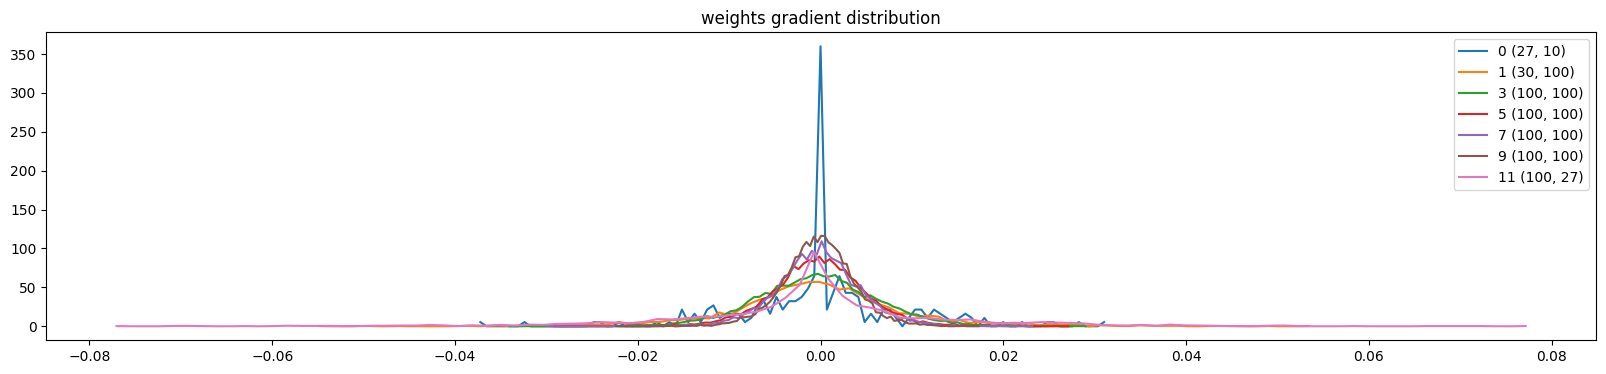

In [113]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### 5.5 Viz #4: data ratio over time

* the grad/data ratio is not that infromative because what matters is the update to the data ratio because that is the amount by which we will actually change the data in these tensors
* log10 for a nicer visualization, we'll keep a track of this for each of the paramters and adding it to the ud tensor
* we plot 2 things in the data ratio over time graph:
  1. we plot the ratios:
    * they evolve over time
    * updates start stabilizing during teaining
  2. an approx. value that is a rough guide of what it roughly should be
    * there are some values in this tensor and the updates to them at every single itertion are no more than roughly 1/1000 of the actual like magnitude in those tensors
    * if this was much larger like if the log10 was -1 then the values are going through a lot of change but the reasons the final layer is an outlier is that this layer was artificially shrunk down to keep the `softmax` unconfident so the data values in the tensor become way too low with the ratio becoming higher -> stablizes over time as the weight starts to learn
  * like that the ratio grpah is not too much above roughly 1e-3 on the log parameter. If it is below 1e-3 that means the parameters are not trained fast enough so if our lr was very low, the plot will show it with the update size being very small. Rather the lr here is kinda a bit high since our line is above the black line of 1e-3
* if we forgot to apply the `fan_in` normalization, so the weights inside the linear layers are just a sample from the gaussian in all those stages
  * we'll know something is off with the gradients being really shrunk with a lot of asymmetry
  * there is a lot of discrepancy in how fast these layers are learning (way too fast)


layer 1 (      Tanh): mean -0.04, std 0.64, saturated: 5.19%
layer 3 (      Tanh): mean -0.01, std 0.54, saturated: 0.41%
layer 5 (      Tanh): mean +0.01, std 0.53, saturated: 0.47%
layer 7 (      Tanh): mean -0.02, std 0.53, saturated: 0.28%
layer 9 (      Tanh): mean +0.01, std 0.54, saturated: 0.25%


Text(0.5, 1.0, 'activation distribution')

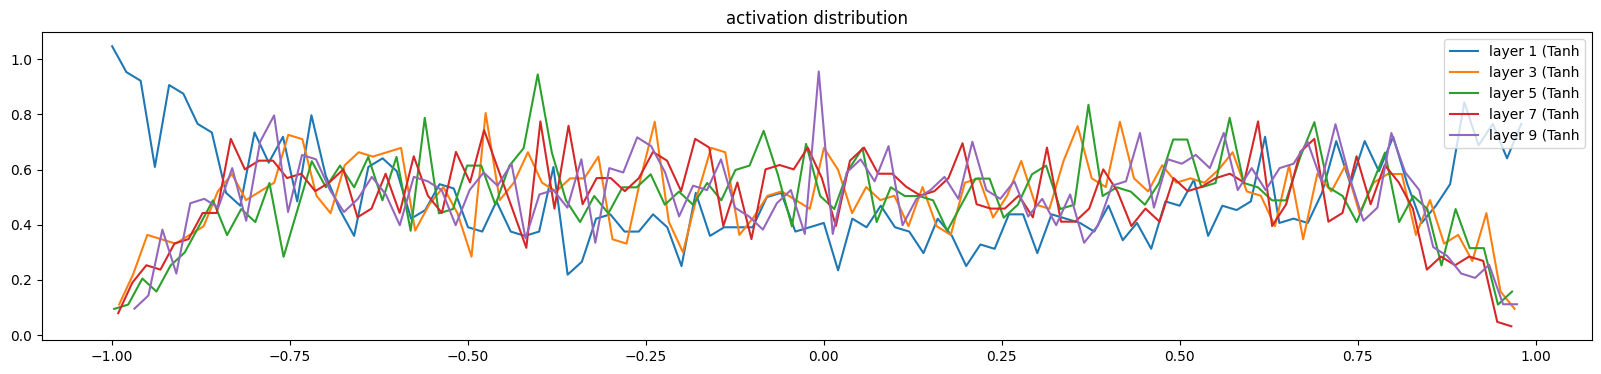

In [114]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000033, std 2.641852e-03
layer 3 (      Tanh): mean +0.000043, std 2.440831e-03
layer 5 (      Tanh): mean -0.000004, std 2.338152e-03
layer 7 (      Tanh): mean +0.000006, std 2.283551e-03
layer 9 (      Tanh): mean +0.000040, std 2.059027e-03


Text(0.5, 1.0, 'gradient distribution')

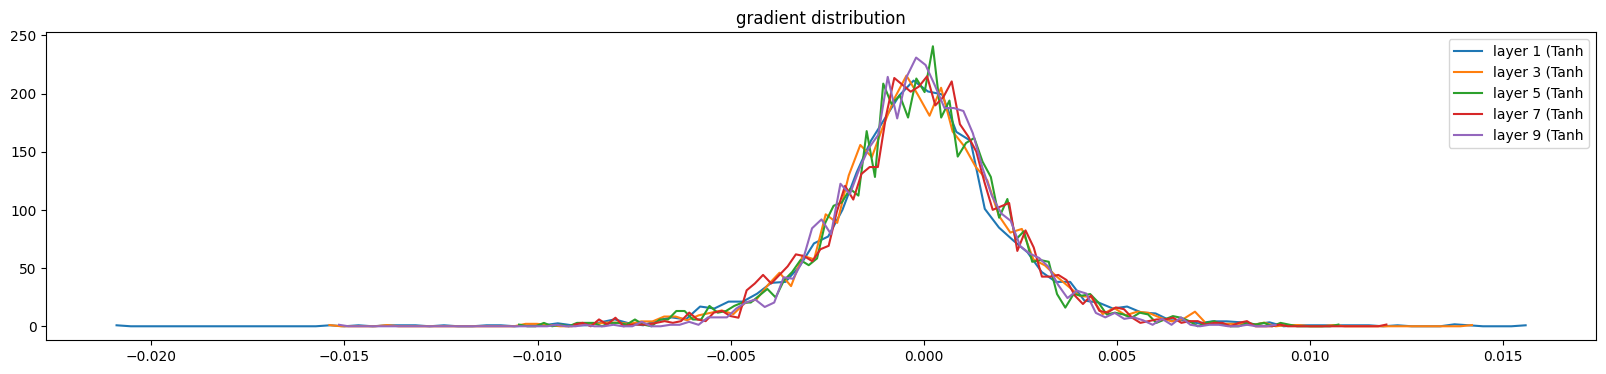

In [115]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000348 | std 8.758368e-03 | grad:data ratio 8.702222e-03
weight  (30, 100) | mean +0.000151 | std 1.007395e-02 | grad:data ratio 5.258169e-02
weight (100, 100) | mean -0.000087 | std 6.662836e-03 | grad:data ratio 6.450022e-02
weight (100, 100) | mean +0.000021 | std 5.148380e-03 | grad:data ratio 4.974074e-02
weight (100, 100) | mean +0.000015 | std 4.545035e-03 | grad:data ratio 4.419325e-02
weight (100, 100) | mean -0.000044 | std 3.829133e-03 | grad:data ratio 3.732290e-02
weight  (100, 27) | mean +0.000000 | std 1.436651e-02 | grad:data ratio 2.251752e-01


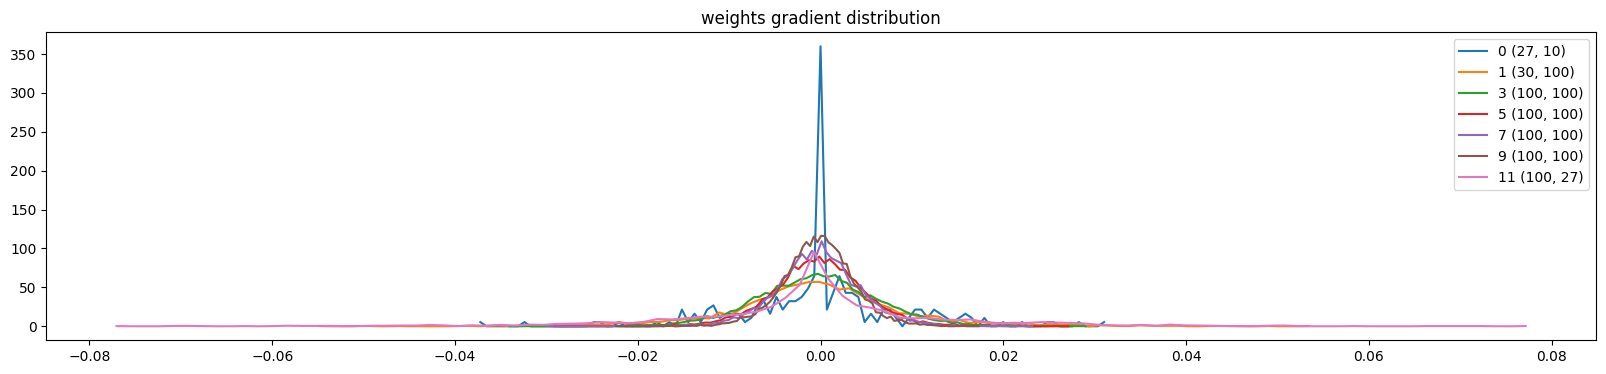

In [116]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

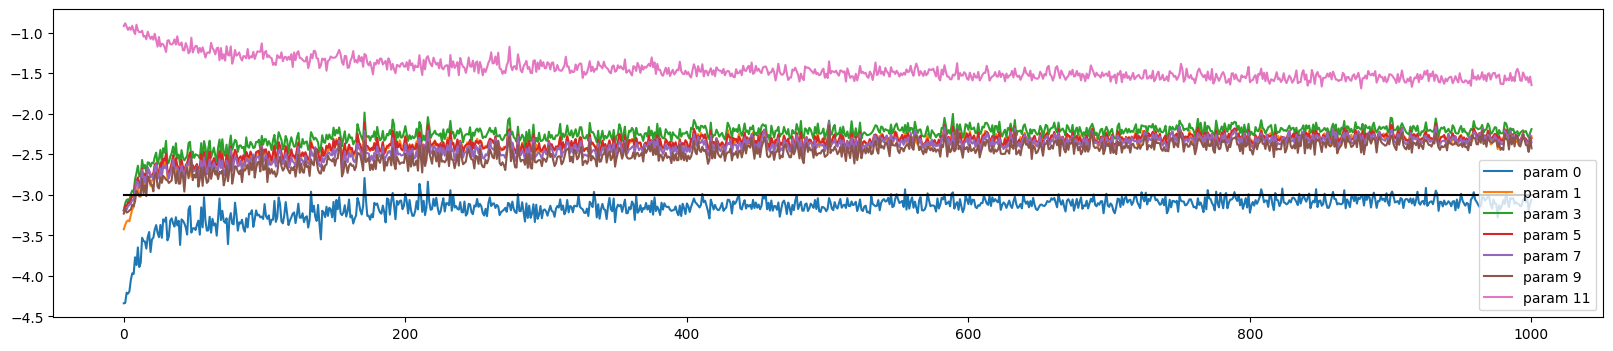

In [117]:
# plotting the update ratios over time
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### 5.6 Bringing back batchnorm

* the gain has to very precisely calculated so let's introduce batchnorm layer
* we change the gamma instead of weight now because gamma in batchnorm is the variable that multiplicatevely interacts with the output of that normalization
* all graphs look homogenous
* we go a little above 1e-3 in the ratio graph but not too much
* what we've gained is that we're going to be less brittle w.r.t to the gain of these so for e.g if the gain is 0.2, the activations will be inaffected due to the normalization layer -> the updates will however change because of the backward pass of the batchnorm and how the scale of the incoming activations interacts in the batchnorm and the backward pass, this is actually changing the scale of the updates on these parameters so the gradients of these weights are affected so we don't get a complete pass to pass any gain, but eveyrthing else is significantly robust in terms of the forward, backward and weights. You might just have to change your lr if your sufficiently changing your gain
* with batchnorm we don't really have to normalize with `fan_in` and can work with a random gaussian as well
* we are signficantly robust to the gain of these linear layers whether or not we have to apply the `fan_in` and then we can change the gain but we do have to worry a little about the update scales, and make sure the lr is properly calibrated, but the activations of the forward backward pass and the updates are looking signficantly well behaved except the global stage which we are adjusting

In [119]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [120]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

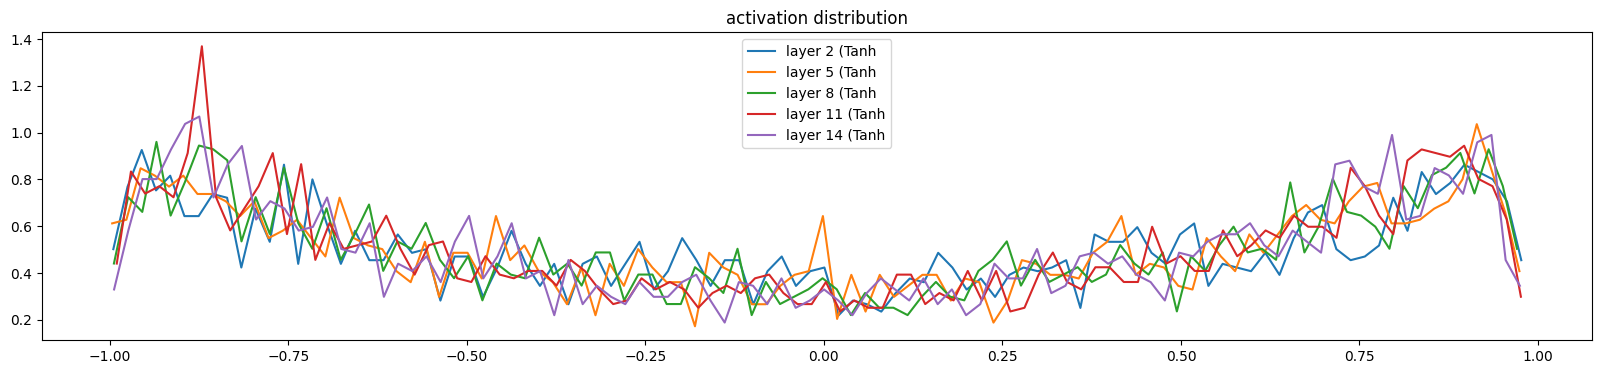

In [121]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

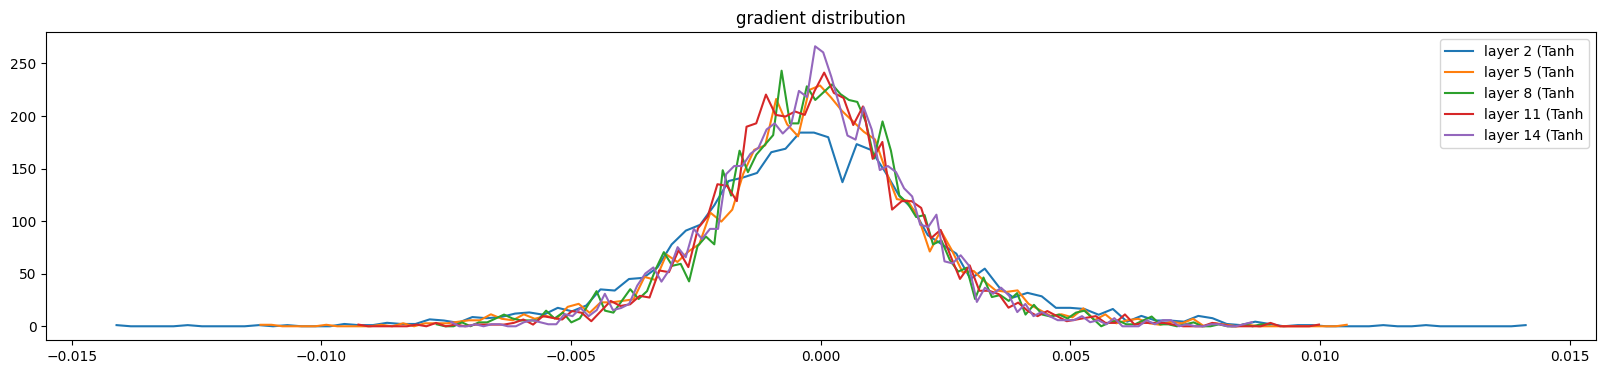

In [122]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012626e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132873e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672203e-03 | grad:data ratio 5.570123e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


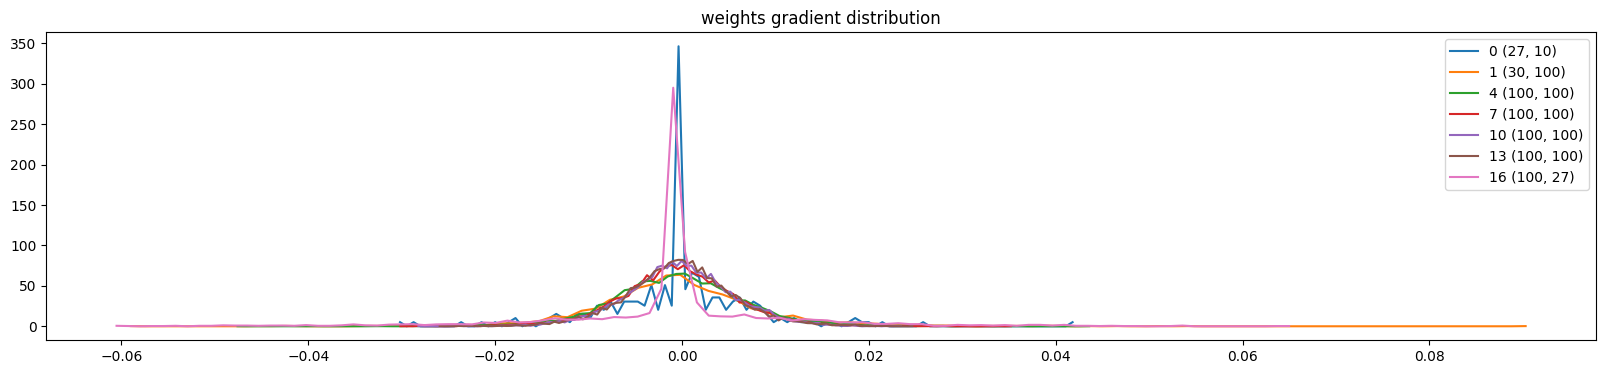

In [123]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


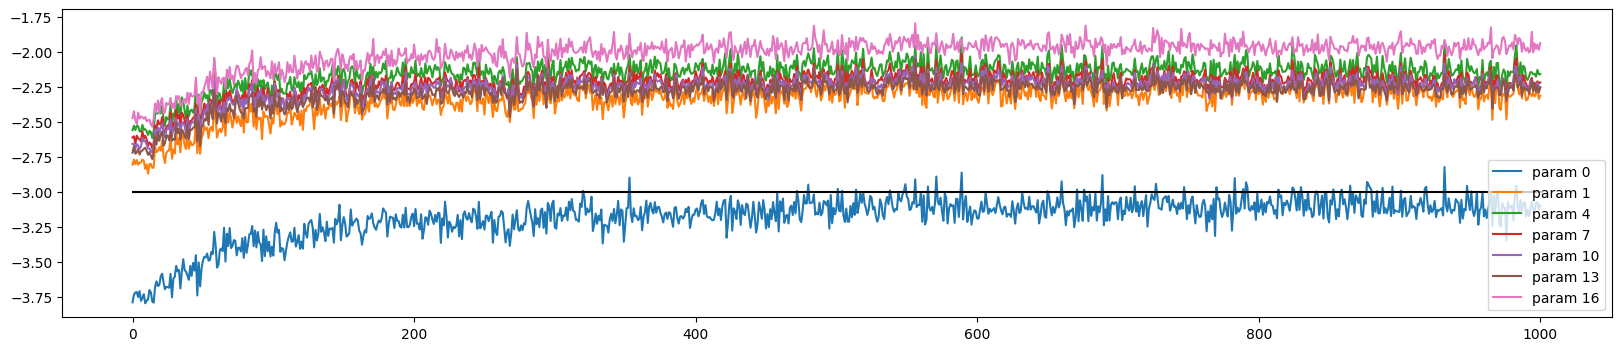

In [124]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

## Final summary

There are a few things I was hoping to achieve in this.

* Number one, I wanted to introduce the object-based visualization, which is one of the first modern animations that we're looking into, that helped stabilize very deep volumes in their trailer. And I hope you understand the master of logic she knows, and how it would be used in your work.

* Number two, I was hoping to fortify and solidify the program, and ramp it up into these modules. So, like, Moon, Astro, Moonbeam, Tendon, etc. these are layers, modules, and they can be stacked up into your units, like, a couple billion units. And these layers actually exist in Python, and if you can approach them, then you can actually do that, for example. Because you can just use Python to write anything, and then dump it to all these different links. And actually, everything will just work, because the API that I've developed here is identical to the API that I've introduced. And the implementation also is basically, as far as I'm aware, identically.

* Number three, I tried to introduce you to the diagnostic tools that you use to understand what in the world ever is in a given state in that movement. So we are looking at the statistics and histograms and activation. We're looking at the forward-passive cadence and pattern shifts, the backward-passive radians. And then also, we're looking at the weights that are going to be affiliated as part of the classic radial set. And we're looking at the radial system deviations and also the ratio of the gradients of the field. Even better, the updates of the field. And we saw that typically we don't actually look at it as a single snapshot of horizontal time. It's a larger calculation. Typically, people look at this as over time, just like I'm doing here. And they look at these update and data ratios, and they make sure everything is OK. And in particular, I said that 1-3, basically negative 3 on the left side, is a good rough mistake for measuring this ratio. And if it's way too high, then probably the learning rate, or the updates are too big. If it's way too small, then the lower layer is probably too small. So that's just some of the things you can play with when you're trying to get your model into 2D.


Now there's a number of things I did not teach.


* I did not try to beat our previous performance testing example by introducing the bash layer. Actually, I did try. And I found that I used the floating-weight-line-in-depth method that I described before. I tried to train the bash for a layer, a bash for a layer, the last one layer of the content. And I actually ended up with results that are very, very similar to what we obtained. And that's because our focus now is not on the optimization, which is what last one is about. The performance at this stage is followed by what I suspect is the context level of our content. So, currently we are taking three characters to create the fourth one, and I think we need to go deeper into the story.
  * I think it's a bit like... It's as if everyone's going to go back to the old town. The audience is not going to go back to the old town. They're just going to be stuck there.

* so you may have found some of the parts here unintuitive. I mean, you're slightly confused about, OK, if I change the angle, how come that mean is lower? I didn't go into the full detail because you have to actually look at the path capacity of these different layers and get an intuitive understanding of how all of it works. And I did not go into that in this lecture. The purpose really was just to introduce you to diagnostic tools for the data model. and there's still a lot of work to be done to understand the initialization of the internet. But you shouldn't feel too bad because honestly we are getting to the cutting edge of where the field is. We certainly haven't solved the initialization and we haven't solved the background issue. And these are still very much an active area of research.

## Extra

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

In [ ]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())